### FUENTE: https://github.com/taspinar/siml/blob/master/notebooks/WV2%20-%20Visualizing%20the%20Scaleogram%2C%20time-axis%20and%20Fourier%20Transform.ipynb

In [2]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from waveletFunctions import wave_signif, wavelet
import sys

sys.path.append('../augerscalerpy')
from scaler_cleaning import scaler_clean, plot_data

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [7]:
dataset = "https://raw.githubusercontent.com/taspinar/siml/master/datasets/sst_nino3.dat.txt"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

In [42]:
########### DATOS JENNIFER
# READ THE DATA
#sst = np.loadtxt('sst_nino3.dat')  # input SST time series
datos = scaler_clean('../scaler_datasets/scaler_300s_FINAL.csv','scaler_300s_N9')
#sst.set_index('Date', inplace=True) # Establece la columna 'Date' como el índice del DataFrame
datos = datos.fillna(datos.mean())
datos['Date'] = pd.to_datetime(datos['Date'])
datos.set_index('Date', inplace=True)
datos = datos.resample('1D').mean().interpolate(method='linear')
sst = datos['ScalerCorr'].values
sst = sst - np.mean(sst)
variance = np.std(sst)
print("variance = ", variance)
############################## PARAMETROS
N = len(sst)
t0=2006
dt=1/365
time = np.arange(0, N) * dt + t0
signal = sst

Hay  (13663, 6) líneas vacías
variance =  14.068987798635149


/home/jennifer/Documentos/msc_tesis/scaler_for_solar_analysis/wave_python/../augerscalerpy/scaler_cleaning.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SDOK["Date"] = datetime.values


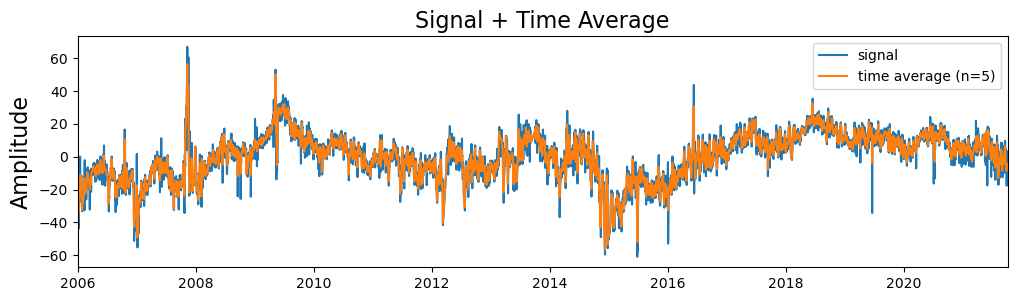

In [43]:
# First lets load the el-Nino dataset, and plot it together with its time-average

def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 3)
plt.show()


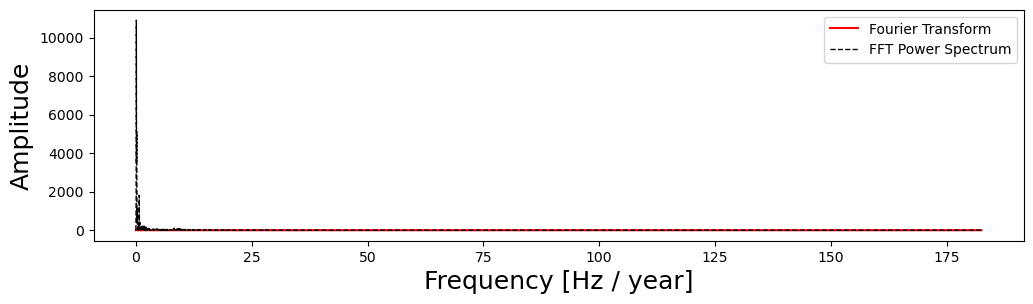

In [72]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        #ax.set_ylim(ylim[0], -1)
    ax.legend()

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plot_fft_plus_power(ax, time, signal)
plt.show()

/home/jennifer/.local/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


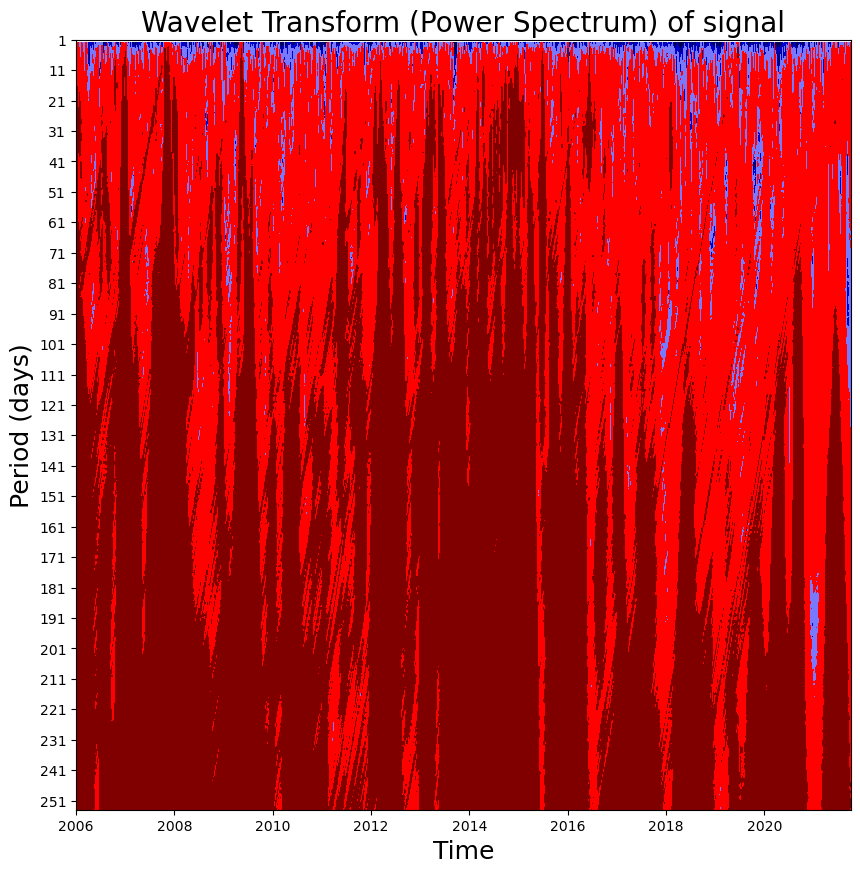

In [73]:
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = (1. / frequencies)*365.0
    #levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    #contourlevels = np.log2(levels)
    contourlevels = levels

    
    #im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    im = ax.contourf(time, period, np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    #yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    yticks = np.arange(1, 255, 10)
    #ax.set_yticks(np.log2(yticks))
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    #ylim = ax.get_ylim()
    #ax.set_ylim(ylim[0], -1)
    return yticks, ylim, period

scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (days)'
xlabel = 'Time'

fig, ax = plt.subplots(figsize=(10, 10))
a,b,c= plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
plt.show()

In [55]:
c

array([0.00547945, 0.0109589 , 0.01643836, 0.02191781, 0.02739726,
       0.03287671, 0.03835616, 0.04383562, 0.04931507, 0.05479452,
       0.06027397, 0.06575342, 0.07123288, 0.07671233, 0.08219178,
       0.08767123, 0.09315068, 0.09863014, 0.10410959, 0.10958904,
       0.11506849, 0.12054795, 0.1260274 , 0.13150685, 0.1369863 ,
       0.14246575, 0.14794521, 0.15342466, 0.15890411, 0.16438356,
       0.16986301, 0.17534247, 0.18082192, 0.18630137, 0.19178082,
       0.19726027, 0.20273973, 0.20821918, 0.21369863, 0.21917808,
       0.22465753, 0.23013699, 0.23561644, 0.24109589, 0.24657534,
       0.25205479, 0.25753425, 0.2630137 , 0.26849315, 0.2739726 ,
       0.27945205, 0.28493151, 0.29041096, 0.29589041, 0.30136986,
       0.30684932, 0.31232877, 0.31780822, 0.32328767, 0.32876712,
       0.33424658, 0.33972603, 0.34520548, 0.35068493, 0.35616438,
       0.36164384, 0.36712329, 0.37260274, 0.37808219, 0.38356164,
       0.3890411 , 0.39452055, 0.4       , 0.40547945, 0.41095

/home/jennifer/.local/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/tmp/ipykernel_20830/1300772663.py:20: RuntimeWarning: divide by zero encountered in divide
  scales = 1./f_values


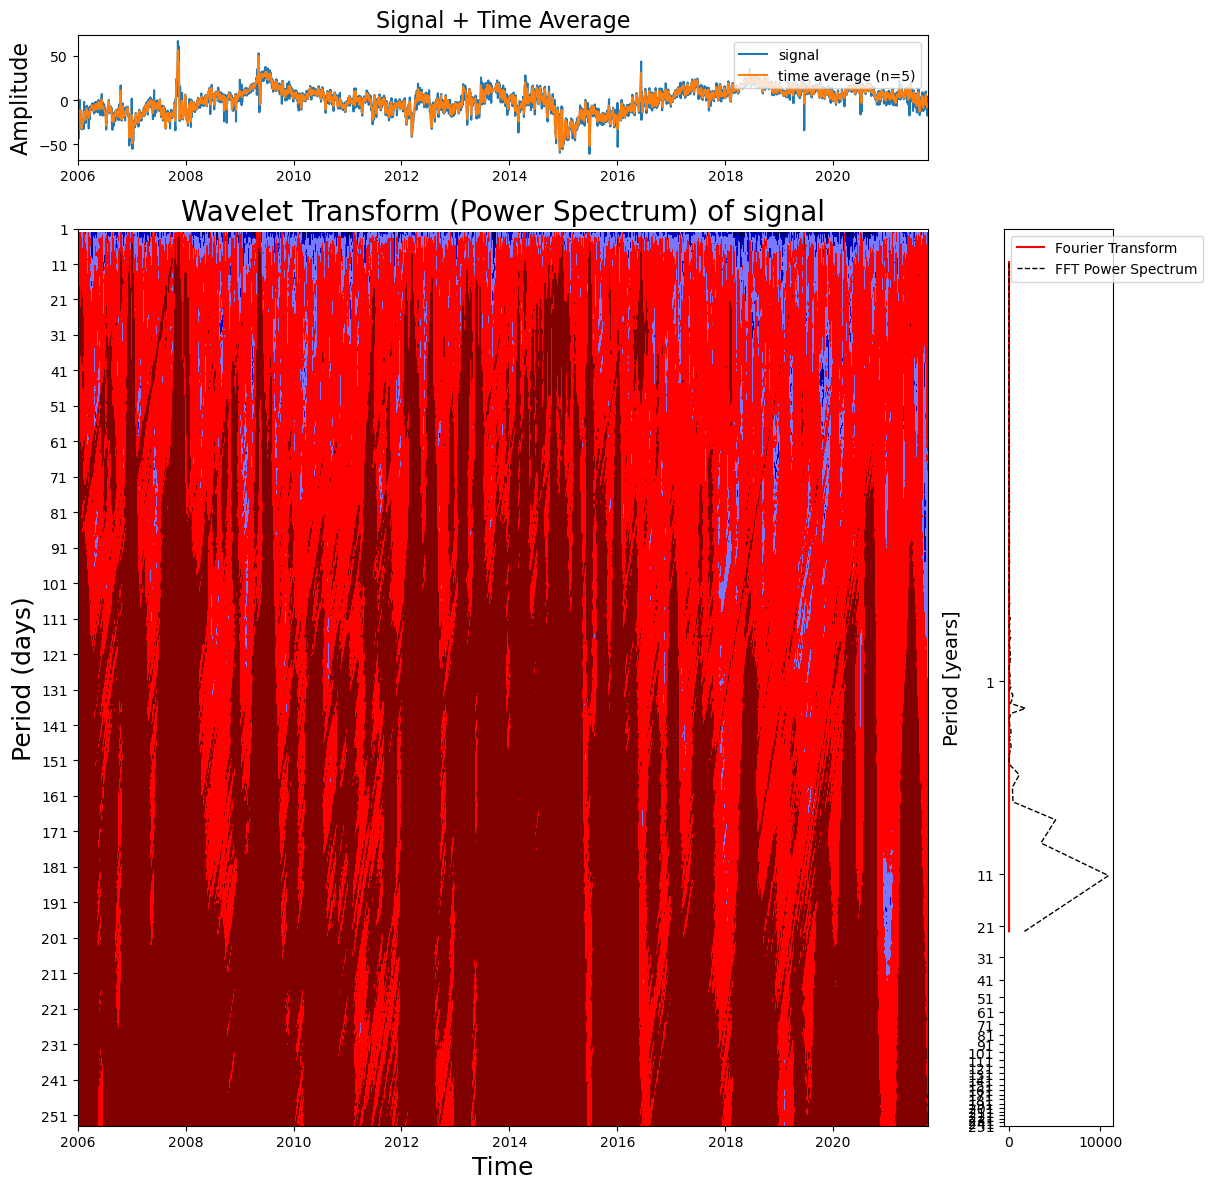

In [75]:
############## TODO EN UNA SOLA FIGURA


fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[0, 0:5])
bottom_left_ax = fig.add_subplot(spec[1:, 0:5])
bottom_right_ax = fig.add_subplot(spec[1:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim, c = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.savefig('WAVELET_beauty.png')
plt.show()